---
title: "Instrumental variable analysis with a binary outcome using statsmodels"
mathjax: true
toc: true
toc_sticky: true
categories: [data science, statistics]
---

Here is an additional post on instrumental variable (IV) analysis. This follows an exercise where I employed two methods of IV analysis, [comparing a Bayesian approach with two-stage least squares (2SLS)](https://benslack19.github.io/data%20science/statistics/iv-pymc-sm/). My motivation for these posts is to have a better understanding, ultimately, of Mendelian randomization. The context in which I ultimately want to apply it to is a disease outcome, which is binary. In this post, I explore the Bayesian approach of IV analysis towards a binary outcome.

In [8]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pytensor.tensor as pt
import scipy.stats as stats
import seaborn as sns
import statsmodels.api as sm
from scipy.special import expit
from utils import draw_causal_graph, standardize

In [2]:
RANDOM_SEED = 73
np.random.seed(RANDOM_SEED)
sns.set_context("talk")
sns.set_palette("colorblind")
cb_palette = sns.color_palette()

# Causal graph of example dataset with binary outcome

We'll return to the wages and education example from Chapter 14 of Statistical Rethinking. However, instead of using wages as our outcome, we'll tweak this by creating a binary outcome from wages, which I'll refer to as $R$ for "rich". The causal diagram will look the same as a traditional IV setup.

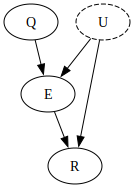

In [3]:
draw_causal_graph(
    edge_list=[("Q", "E"), ("U", "E"), ("U", "R"), ("E", "R")],
    node_props={"U": {"style": "dashed"}},
    graph_direction="TD",
)

Per usual, we'll use this to generate a simulated dataset. We'll use the same code but this time derive `R` from `W`. The rationale being those with higher wages are more likely to be rich. We’ll still making the influence of education on wages (`bEW_sim`) equal to 0. We'll want to get this value back in our statistical models, even though we'll be using `R` as our ultimate outcome variable.

A key conceptual point is use of a logit link function to produce `R` from `W`.  Additionally, we'll make use of a [binomial generalized linear model](https://benslack19.github.io/data%20science/statistics/multilevel_modeling_01/).

In [28]:
def generate_data(num_subjects, n_binomial_param, bEW_sim) -> pd.DataFrame:
    """Generate simulated data.

    Parameters
    ----------
    num_subjects
        Number of subjects/rows in data
    n_binomial_param
        Number of "observations" for each subject;
        a parameter in the binomial GLM

    Returns
    -------
    sim_df
        pd.DataFrame

    """

    U_sim = np.random.normal(size=num_subjects)
    Q_sim = np.random.randint(1, 5, size=num_subjects)
    E_sim = np.random.normal(loc=U_sim + Q_sim, size=num_subjects)
    W_sim = np.random.normal(loc=U_sim + bEW_sim * E_sim, size=num_subjects)
    sim_df = pd.DataFrame.from_dict(
        {"W": standardize(W_sim), "E": standardize(E_sim), "Q": standardize(Q_sim)}
    )

    # Use of link functions to generate R
    index_val = sim_df.index.values
    sim_df["R"] = stats.binom.rvs(n=n_binomial_param, p=expit(W_sim))
    sim_df["R_size"] = n_binomial_param

    return sim_df


dat_sim = generate_data(num_subjects=500, n_binomial_param=2, bEW_sim=0)
dat_sim.head()

,W,E,Q,R,R_size
0,1.061073,1.674311,-0.485928,2,2
1,0.462720,0.099933,-0.485928,1,2
2,1.028935,-0.807773,-0.485928,1,2
3,-0.147322,-0.168310,-1.392511,2,2
4,-0.618928,0.758048,0.420654,1,2


As usual, visualizing the data can give us some insight into how the data *appears* and where confounds may mislead. We know that `Q` is a cause of `E` and therefore the association we see is reflective of causation. The bottom-left figure `W` vs. `R` is a logit transformation of the former into the latter. However, both the plots in the right column are a result of the confound `U`. It is driving the relationship between `E` and `W` and therefore we also see an association between `E` and `R`.

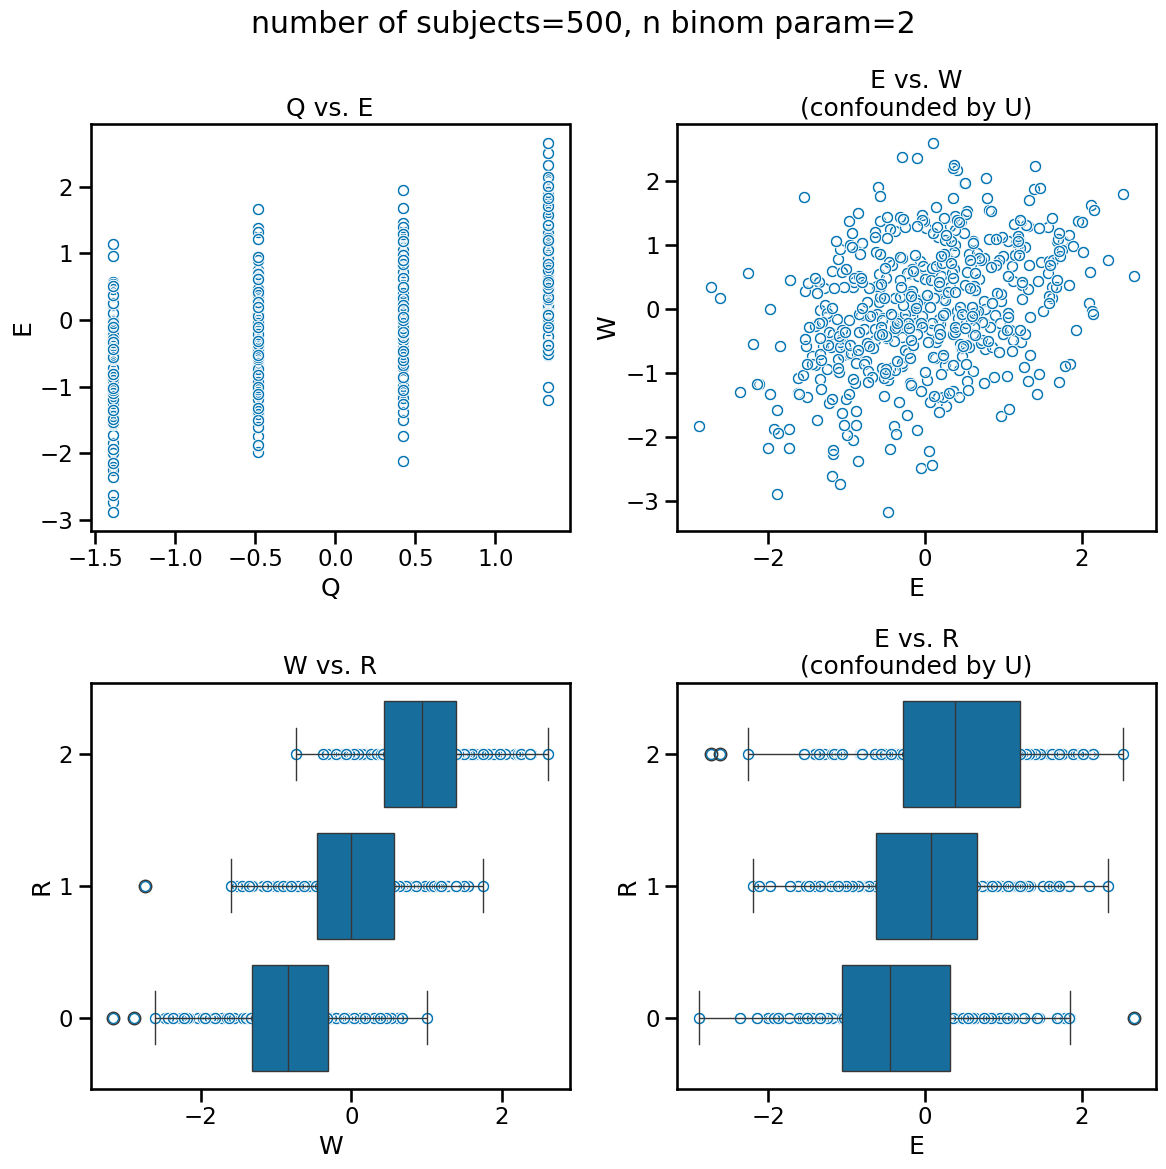

In [29]:
def plot_variable_relationships(sim_df, title):
    f, ((ax0, ax1), (ax2, ax3)) = plt.subplots(2, 2, figsize=(12, 12))

    sns.scatterplot(data=sim_df, x="Q", y="E", marker=r"$\circ$", ax=ax0)
    ax0.set_title("Q vs. E")

    sns.scatterplot(data=sim_df, x="E", y="W", marker=r"$\circ$", ax=ax1)
    ax1.set_title("E vs. W\n(confounded by U)")

    sns.boxplot(data=sim_df, x="W", y="R", orient="h", color=cb_palette[0], ax=ax2)
    sns.scatterplot(data=sim_df, x="W", y="R", marker=r"$\circ$", ax=ax2)
    ax2.invert_yaxis()
    ax2.set_title("W vs. R")

    sns.boxplot(data=sim_df, x="E", y="R", orient="h", color=cb_palette[0], ax=ax3)
    sns.scatterplot(data=sim_df, x="E", y="R", marker=r"$\circ$", ax=ax3)
    ax3.invert_yaxis()
    ax3.set_title("E vs. R\n(confounded by U)")

    f.suptitle(title)
    f.tight_layout()


plot_variable_relationships(dat_sim, "number of subjects=500, n binom param=2")

# Analog to 2SLS

In [30]:
# First stage: Regress education on Q
first_stage = sm.OLS(dat_sim["E"], sm.add_constant(dat_sim["Q"])).fit()

# Predicted education added to df
dat_sim["E_hat"] = first_stage.predict(sm.add_constant(dat_sim["Q"]))
dat_sim.head()

,W,E,Q,R,R_size,E_hat
0,1.061073,1.674311,-0.485928,2,2,-0.312437
1,0.462720,0.099933,-0.485928,1,2,-0.312437
2,1.028935,-0.807773,-0.485928,1,2,-0.312437
3,-0.147322,-0.168310,-1.392511,2,2,-0.895342
4,-0.618928,0.758048,0.420654,1,2,0.270468


In [31]:
# Second stage: Regress wages on predicted education (instrumented)
second_stage = sm.OLS(dat_sim["W"], sm.add_constant(dat_sim["E_hat"])).fit()

# Summary of the second stage regression
second_stage.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      W   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     1.797
Date:                Fri, 21 Jun 2024   Prob (F-statistic):              0.181
Time:                        11:51:38   Log-Likelihood:                -708.57
No. Observations:                 500   AIC:                             1421.
Df Residuals:                     498   BIC:                             1430.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -3.469e-18      0.045  -7.76e-17      1.000      -0.088       0.088
E_hat         -0.0933      0.070     -1.340      0.181      -0.230       0.043
==============================================================================
Omnibus:                        2.841   Durbin-Watson:                   1.997
Prob(Omnibus):                  0.242   Jarque-Bera (JB):                2.917
Skew:                          -0.169   Prob(JB):                        0.233
Kurtosis:                       2.839   Cond. No.                         1.56
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [19]:
dat_sim.head()

,W,E,Q,R,R_size,E_hat
0,1.147366,1.442103,0.428599,1,2,0.292607
1,1.153508,0.386141,-1.372236,2,2,-0.936835
2,0.948497,0.413627,-0.471819,2,2,-0.322114
3,-0.137755,0.193661,-0.471819,1,2,-0.322114
4,-1.653446,-2.076577,-0.471819,1,2,-0.322114


In [21]:
glm_binom = sm.GLM(
    dat_sim[["R_size", "R"]], dat_sim["E_hat"], family=sm.families.Binomial()
)
res = glm_binom.fit()
print(res.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:        ['R_size', 'R']   No. Observations:                  500
Model:                            GLM   Df Residuals:                      499
Model Family:                Binomial   Df Model:                            0
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -557.29
Date:                Fri, 21 Jun 2024   Deviance:                       515.52
Time:                        11:41:14   Pearson chi2:                     387.
No. Iterations:                     3   Pseudo R-squ. (CS):            -0.4068
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
E_hat         -0.0185      0.076     -0.244      0.8

# Positive coefficient

In [32]:
dat_sim_1 = generate_data(num_subjects=500, n_binomial_param=2, bEW_sim=1)
dat_sim_1.head()

,W,E,Q,R,R_size
0,-0.776687,0.135985,0.463191,2,2
1,-0.553068,-0.556273,0.463191,2,2
2,0.312080,-0.004844,-1.346148,2,2
3,0.073053,-0.017003,-0.441479,2,2
4,0.396163,0.290261,-1.346148,2,2


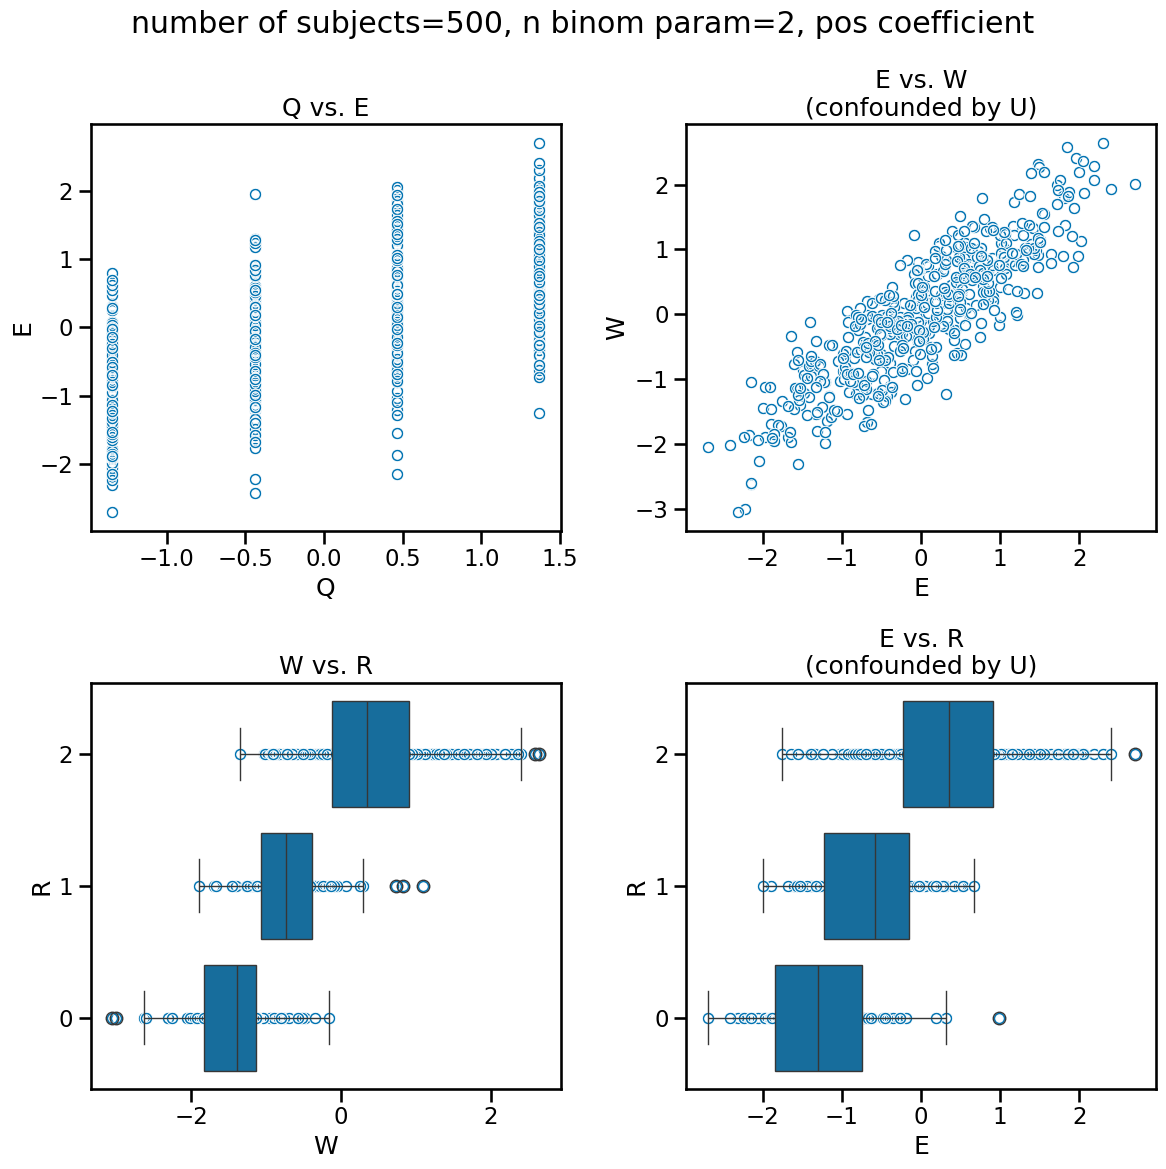

In [33]:
plot_variable_relationships(
    dat_sim_1, "number of subjects=500, n binom param=2, pos coefficient"
)

In [40]:
# First stage: Regress education on Q
first_stage = sm.OLS(dat_sim_1["E"], sm.add_constant(dat_sim_1["Q"])).fit()

# Predicted education added to df
dat_sim_1["E_hat"] = first_stage.predict(sm.add_constant(dat_sim_1["Q"]))
dat_sim_1.head()

,W,E,Q,R,R_size,E_hat
0,-0.776687,0.135985,0.463191,2,2,0.285507
1,-0.553068,-0.556273,0.463191,2,2,0.285507
2,0.312080,-0.004844,-1.346148,2,2,-0.829754
3,0.073053,-0.017003,-0.441479,2,2,-0.272124
4,0.396163,0.290261,-1.346148,2,2,-0.829754


In [41]:
# Second stage: Regress wages on predicted education (instrumented)
second_stage = sm.OLS(dat_sim_1["W"], sm.add_constant(dat_sim_1["E_hat"])).fit()

# Summary of the second stage regression
second_stage.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      W   R-squared:                       0.156
Model:                            OLS   Adj. R-squared:                  0.154
Method:                 Least Squares   F-statistic:                     91.78
Date:                Sun, 23 Jun 2024   Prob (F-statistic):           4.57e-20
Time:                        08:05:45   Log-Likelihood:                -667.18
No. Observations:                 500   AIC:                             1338.
Df Residuals:                     498   BIC:                             1347.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.665e-16      0.041   4.04e-15      1.000      -0.081       0.081
E_hat          0.6400      0.067      9.580      0.000       0.509       0.771
==============================================================================
Omnibus:                        0.674   Durbin-Watson:                   2.050
Prob(Omnibus):                  0.714   Jarque-Bera (JB):                0.667
Skew:                          -0.089   Prob(JB):                        0.716
Kurtosis:                       2.976   Cond. No.                         1.62
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Binomial

In [36]:
dat_sim_1.head()

,W,E,Q,R,R_size,E_hat
0,-0.776687,0.135985,0.463191,2,2,0.285507
1,-0.553068,-0.556273,0.463191,2,2,0.285507
2,0.312080,-0.004844,-1.346148,2,2,-0.829754
3,0.073053,-0.017003,-0.441479,2,2,-0.272124
4,0.396163,0.290261,-1.346148,2,2,-0.829754


In [39]:
glm_binom = sm.GLM(
    endog=dat_sim_1[["R_size", "R"]],
    exog=dat_sim_1["E_hat"],
    family=sm.families.Binomial(),
)
res = glm_binom.fit()
print(res.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:        ['R_size', 'R']   No. Observations:                  500
Model:                            GLM   Df Residuals:                      499
Model Family:                Binomial   Df Model:                            0
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -515.84
Date:                Fri, 21 Jun 2024   Deviance:                       213.65
Time:                        11:55:04   Pearson chi2:                     160.
No. Iterations:                     3   Pseudo R-squ. (CS):           -0.04090
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
E_hat         -0.1881      0.077     -2.429      0.0

# Wald statistic

Ratio of coefficient of instrument to outcome / Ratio of coefficient of instrument to exposure

In [46]:
# First stage: Regress education on Q
first_stage = sm.OLS(dat_sim["E"], sm.add_constant(dat_sim["Q"])).fit()
first_stage.params.iloc[1]

0.6429691753347397

In [47]:
# Effect of Q on outcome: Regress W on Q
total_stage = sm.OLS(dat_sim["W"], sm.add_constant(dat_sim["Q"])).fit()
total_stage.params.iloc[1]

-0.05995925581174005

In [48]:
wald_statistic = total_stage.params.iloc[1] / first_stage.params.iloc[1]
print(wald_statistic)

-0.09325370190650949


## Comparison with 2SLS

In [50]:
# Predicted education added to df
dat_sim["E_hat"] = first_stage.predict(sm.add_constant(dat_sim["Q"]))

# Second stage: Regress wages on predicted education (instrumented)
second_stage = sm.OLS(dat_sim["W"], sm.add_constant(dat_sim["E_hat"])).fit()

# Summary of the second stage regression
second_stage.params.iloc[1]

-0.09325370190650949

# Why does this work?

see here: https://bkenkel.com/pdaps/instruments.html#the-wald-estimator

Iterate by seeing how sample size affects estimate

In [80]:
bEW_mediator = 1
num_subjects = 100
Q_mediator = np.random.randint(1, 5, size=num_subjects)
E_mediator = np.random.normal(loc=Q_mediator, size=num_subjects)
W_mediator = np.random.normal(loc=bEW_mediator * E_mediator, size=num_subjects)
dat_sim_mediator = pd.DataFrame.from_dict(
    {
        "W": standardize(W_mediator),
        "E": standardize(E_mediator),
        "Q": standardize(Q_mediator),
    }
)

dat_sim_mediator.head()

,W,E,Q
0,0.090761,-0.743328,0.268576
1,0.558261,0.511936,1.194701
2,-1.811134,-1.515530,-0.657548
3,0.196355,0.700411,1.194701
4,-0.910784,-0.082130,0.268576


In [81]:
first_stage_mediator = sm.OLS(
    dat_sim_mediator["E"], sm.add_constant(dat_sim_mediator["Q"])
).fit()
first_stage_mediator.params.iloc[1]

0.6990197779721689

In [82]:
# Predicted education added to df
dat_sim_mediator["E_hat"] = first_stage_mediator.predict(
    sm.add_constant(dat_sim_mediator["Q"])
)

second_stage_mediator = sm.OLS(
    dat_sim_mediator["W"], sm.add_constant(dat_sim_mediator["E"])
).fit()  # still use predicted values
second_stage_mediator.params.iloc[1]

0.813205992339529

In [83]:
total_mediator = sm.OLS(
    dat_sim_mediator["W"], sm.add_constant(dat_sim_mediator["Q"])
).fit()
total_mediator.params.iloc[1]

0.5238113253809018

In [84]:
total_mediator.params.iloc[1] / first_stage_mediator.params.iloc[1]

0.7493512227943815

In [85]:
(
    total_mediator.params.iloc[1] / first_stage_mediator.params.iloc[1]
) - second_stage_mediator.params.iloc[1]

-0.06385476954514746

# MR example

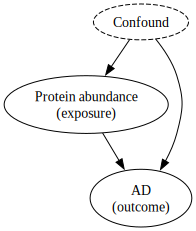

In [100]:
draw_causal_graph(
    edge_list=[
        #("Genotype\n(instrument)", "Protein abundance\n(exposure)"),
        ("Confound", "Protein abundance\n(exposure)"),
        ("Confound", "AD\n(outcome)"),
        ("Protein abundance\n(exposure)", "AD\n(outcome)"),
    ],
    node_props={"Confound": {"style": "dashed"}},
    graph_direction="TD",
)

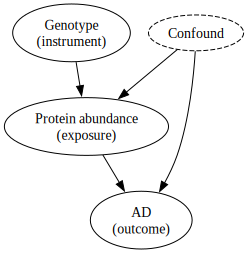

In [99]:
draw_causal_graph(
    edge_list=[
        ("Genotype\n(instrument)", "Protein abundance\n(exposure)"),
        ("Confound", "Protein abundance\n(exposure)"),
        ("Confound", "AD\n(outcome)"),
        ("Protein abundance\n(exposure)", "AD\n(outcome)"),
    ],
    node_props={"Confound": {"style": "dashed"}},
    graph_direction="TD",
)

# Summary and acknowledgements

My motivation for this post was understanding how to implement IV analysis with a binary outcome. I also ran an experiment to determine appropriate sample sizes. Some of the coding implementation was tricky for me initially. Thanks to [the man](https://xcelab.net/rm/) himself for providing some [help](https://x.com/rlmcelreath/status/1798972577387339782).

In [199]:
%load_ext watermark
%watermark -n -u -v -iv -w

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Last updated: Wed Jun 12 2024

Python implementation: CPython
Python version       : 3.12.3
IPython version      : 8.24.0

pymc      : 5.15.0
matplotlib: 3.8.4
scipy     : 1.13.0
seaborn   : 0.13.2
numpy     : 1.26.4
pandas    : 2.2.2
arviz     : 0.18.0
pytensor  : 2.20.0

Watermark: 2.4.3

